In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/tamil_sentiment")
df

,tamil_cleaned,label
0,வானி போஜன் ரசிகர்கள் சோலியைப் போல வாங்கிடா வெண...,1
1,நான் உன்னை விரும்புகிறேன் அஜித் நான் விரும்புக...,0
2,என்னாயா டிரெய்லர் கு முடி எல்லம் வேரா நிலை,0
3,விஜய் அண்ணா உர் மாஸ் தெர்ரி,0
4,நம்ப நடே நாசாமா,2
...,...,...
37700,,1
37701,நாடக காதல்இதை தான் இந்தவெள்ளாள பிள்ளைமார் சார்...,0
37702,சூப்பர் எஸ்கே,3
37703,குறைந்தபட்ச எம் வியா வரா வெப்போமா அனைத்து தாலா...,0


In [ ]:
df.dtypes

tamil_cleaned    object
label             int64
dtype: object

In [ ]:
df.shape

(37705, 2)

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
max_length = 512
batch_size = 6

# Instantiate the tokenizer for DistilBERT
model_name = 'distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# Assuming you have four labels: 0, 1, 2, 3
num_labels = 4

def convert_example_to_feature(sentiment):
    return tokenizer.encode_plus(sentiment,
                                 add_special_tokens=True,
                                 max_length=max_length,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 truncation=True
                                 )

In [ ]:
def map_example_to_dict(row):
    distilbert_input = convert_example_to_feature(row['tamil_cleaned'])
    return {
        "input_ids": distilbert_input['input_ids'],
        "attention_mask": distilbert_input['attention_mask'],
    }, tf.keras.utils.to_categorical(row['label'], num_classes=num_labels)

In [ ]:
def encode_examples(df, limit=-1):
    if limit > 0:
        df = df.head(limit)

    input_ids_list = []
    attention_mask_list = []
    label_list = []

    for _, row in df.iterrows():
        example_dict, label = map_example_to_dict(row)
        input_ids_list.append(example_dict['input_ids'])
        attention_mask_list.append(example_dict['attention_mask'])
        label_list.append(label)

    return (
        tf.convert_to_tensor(input_ids_list),
        tf.convert_to_tensor(attention_mask_list),
        tf.convert_to_tensor(label_list)
    )

In [ ]:
# Encode the dataset for DistilBERT
train_dataset = encode_examples(train)
test_dataset = encode_examples(test)

In [ ]:
# Assuming you have 4 classes in your dataset
num_classes = 4

# Model initialization for DistilBERT
model_name = 'distilbert-base-multilingual-cased'
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Choosing Adam optimizer
learning_rate = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# Loss function: Categorical Crossentropy
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Compile the model for DistilBERT
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Assuming you have the train_dataset from the previous code
input_ids, attention_mask, labels = train_dataset

# Assuming you have the test_dataset from the previous code
val_input_ids, val_attention_mask, val_labels = test_dataset

In [ ]:
checkpoint_path = "distilbert_training_checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [ ]:
history = model.fit(
    x={'input_ids': input_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=2,  # Adjust as needed
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'attention_mask': val_attention_mask},
        val_labels
    ),
    callbacks=[checkpoint_callback]
)

In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("/content/drive/MyDrive/distilbert_training_checkpoint_model_saved_at_pause.ckpt")

In [ ]:
# Later, when you want to resume training, load the saved model state
model.load_weights("/content/drive/MyDrive/distilbert_training_checkpoint_model_saved_at_pause.ckpt")

In [ ]:
history = model.fit(
    x={'input_ids': input_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=2,  # Adjust as needed
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'attention_mask': val_attention_mask},
        val_labels
    ),
    callbacks=[checkpoint_callback]
)

Epoch 1/2
5028/5028 [==============================] - ETA: 0s - loss: 0.8772 - accuracy: 0.6569
Epoch 1: val_loss did not improve from 0.95480
5028/5028 [==============================] - 2106s 419ms/step - loss: 0.8772 - accuracy: 0.6569 - val_loss: 0.9559 - val_accuracy: 0.6263
Epoch 2/2
5028/5028 [==============================] - ETA: 0s - loss: 0.7874 - accuracy: 0.6926
Epoch 2: val_loss did not improve from 0.95480
5028/5028 [==============================] - 2108s 419ms/step - loss: 0.7874 - accuracy: 0.6926 - val_loss: 0.9563 - val_accuracy: 0.6406


In [ ]:
train_loss_history=[1.0283,0.9468]
train_accuracy_history=[0.6002,0.6248]
val_loss_history=[0.9807,0.9548]
val_accuracy_history=[0.6100,0.6250]

In [ ]:
# Store metrics in lists
train_loss_history.extend(history.history['loss'])
train_accuracy_history.extend(history.history['accuracy'])
val_loss_history.extend(history.history['val_loss'])
val_accuracy_history.extend(history.history['val_accuracy'])

In [ ]:
print("train_loss_history : ",train_loss_history)
print("train_accuracy_history : ",train_accuracy_history)
print("val_loss_history : ",val_loss_history)
print("val_accuracy_history : ",val_accuracy_history)

train_loss_history :  [1.0283, 0.9468, 0.8772314786911011, 0.7873606085777283]
train_accuracy_history :  [0.6002, 0.6248, 0.6569420695304871, 0.6925805807113647]
val_loss_history :  [0.9807, 0.9548, 0.9559434652328491, 0.9563338160514832]
val_accuracy_history :  [0.61, 0.625, 0.6263095140457153, 0.6406311988830566]


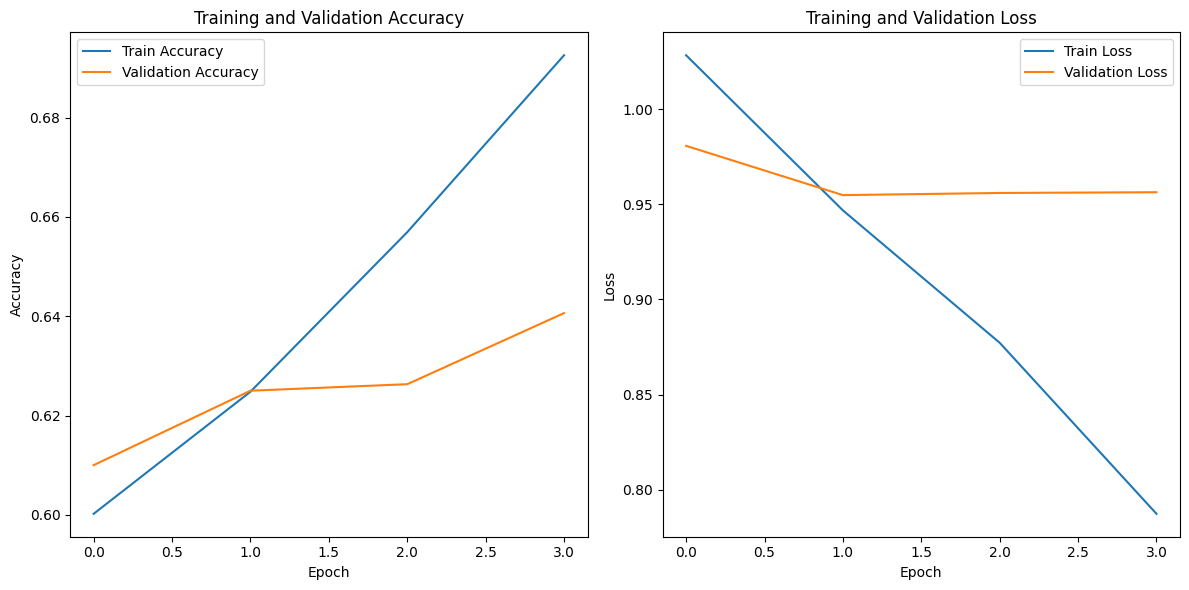

In [ ]:
#Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(
    x={'input_ids': val_input_ids, 'attention_mask': val_attention_mask}
)

236/236 [==============================] - 149s 615ms/step


In [ ]:
# Convert predictions to labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert one-hot encoded true labels to categorical labels
true_labels = np.argmax(val_labels.numpy(), axis=1)

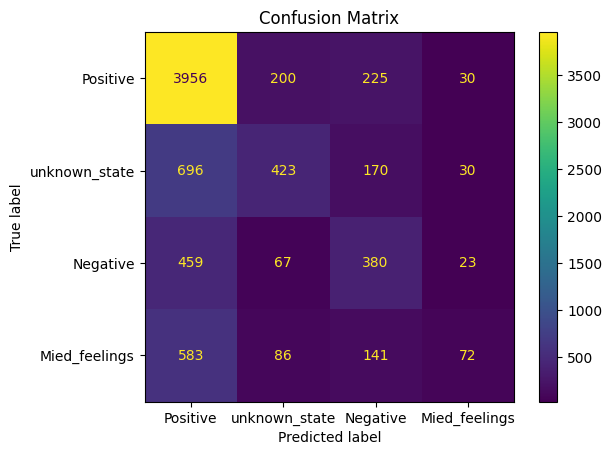

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive','unknown_state','Negative','Mied_feelings'])
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Positive','unknown_state','Negative','Mied_feelings'])
print(class_report)

               precision    recall  f1-score   support

     Positive       0.69      0.90      0.78      4411
unknown_state       0.55      0.32      0.40      1319
     Negative       0.41      0.41      0.41       929
Mied_feelings       0.46      0.08      0.14       882

     accuracy                           0.64      7541
    macro avg       0.53      0.43      0.43      7541
 weighted avg       0.61      0.64      0.60      7541



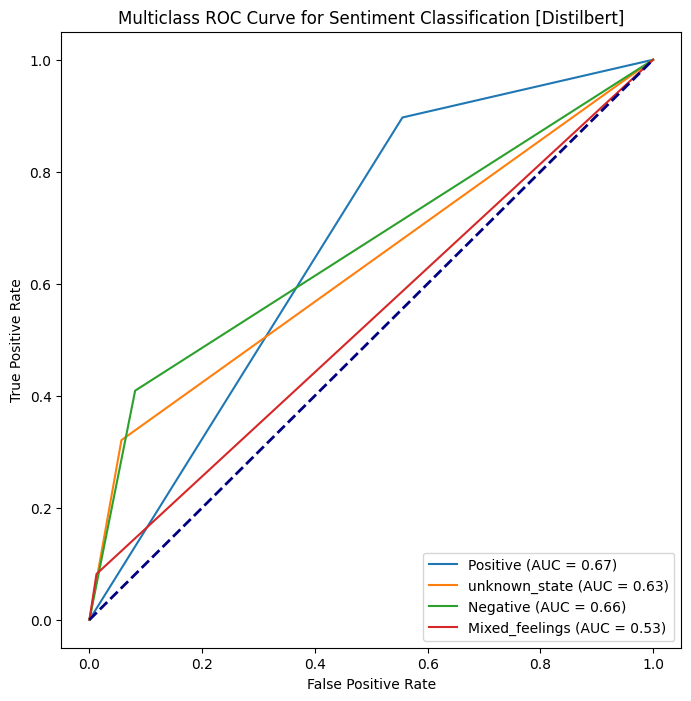

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have four labels
labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Calculate ROC-AUC score for each class
roc_auc_scores = []
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(true_labels == i, predicted_labels == i)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(true_labels == i, predicted_labels == i)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Sentiment Classification [Distilbert]')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("/content/drive/MyDrive/distilbert_training_checkpoint_model_saved_at_pause1.ckpt")